<h1><center> ML Assignment (Form Document Classifier) 
    - Sept 2023
</center></h1>

## Problem statement

The objective of this assignment is to build an NLP solution for the provided dataset. 
The dataset consists of scanned documents from an archive (https://www.sec.gov/Archives/edgar/vprr/index.html)

- Build a predictive model that can categorize a form into one of multiple form types (such as Form D, Form X, Form 13F etc)

#### Table of Contents

* **Data Loading / Preparation:** Load the data and understand the basic structure of the dataset.

* **Data Preprocessing:** Since the data consist of only PDFs, we have to convert them into Images for further processing / model building steps

* **Feature Engineering (Image Augmentation / Transformation,if any):** Create new features that might help improve the model's performance. Also, select the most relevant features for the model.

* **Model Building:** Train the model using different machine learning algorithms.

* **Model Evaluation**: Evaluate the model's performance using appropriate metrics.

* **Model Deployment**: Used Gradio to deploy the model (Pls check src/main.py)

### Data Loading / Preparation

#### Import libraries

In [1]:
# Import libraries
import os


# Deep learning libraries - Tensorflow
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, MaxPooling2D, Conv2D, Dropout, BatchNormalization
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
# from keras.utils import np_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import *

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

# Other libaries
from pdf2image import convert_from_path
import pytesseract
import tempfile
from tqdm.notebook import tqdm

# Image augmentation
import cv2
import albumentations as A


#### Set Train, Test paths

In [2]:
root_dir = "../data"

train_pdfs_dir = os.path.join(root_dir, "train_pdfs")
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")

> Note: All files were manually labelled into classes such as Form X, Form 13f, form D etc

#### Check number of documents for each class (Category)

In [8]:
def show_file_counts(dir):
    
    path_dict = dict()
    
    # Loop through train directory to find number of pdfs for each class
    for path in os.listdir(dir):
        path_dict[path] = len(os.listdir(os.path.join(dir, path)))
    
    # Sort by descending values (Class with max number of pdf first)
    path_dict = dict(sorted(path_dict.items(), key=lambda x: x[1])[::-1])
    
   

    return path_dict


In [9]:
print("Number of PDFs present for each class (highest first): \n\n", show_file_counts(train_pdfs_dir))

Number of PDFs present for each class (highest first): 

 {'Form-13F': 199, 'Form-D': 40, '82-Submission-sheet': 27, 'Others': 16, 'Form-X': 11, 'Form-TA': 6, 'Form-19B': 6}


Clearly from the results above, we can see that Form-13F has the highest number of pdfs present as compared to rest of the classes

### Convert PDFs to Image

In [6]:
# Loop through PDFs dir
for form_category_name in os.listdir(train_pdfs_dir):

    # Image dir
    form_category_folder_name = os.path.join(train_dir, form_category_name)

    # PDFs dir
    form_category_pdf_folder_name = os.path.join(train_pdfs_dir, form_category_name)
    
    print(form_category_folder_name, os.path.isdir(form_category_folder_name))
    if not os.path.isdir(form_category_folder_name):
        os.mkdir(form_category_folder_name)


    for pdf_path in tqdm(os.listdir(form_category_pdf_folder_name)):
        pdf_full_path = os.path.join(form_category_pdf_folder_name, pdf_path)      
        
        with tempfile.TemporaryDirectory() as path:
            # Convert PDF to Image (Only consider 1st page)
            images_from_path = convert_from_path(pdf_full_path, output_folder=form_category_folder_name, fmt='png', first_page=1, last_page=1)
            

../data\train\82-Submission-sheet True


  0%|          | 0/27 [00:00<?, ?it/s]

../data\train\Form-13F True


  0%|          | 0/199 [00:00<?, ?it/s]

../data\train\Form-19B True


  0%|          | 0/6 [00:00<?, ?it/s]

../data\train\Form-D True


  0%|          | 0/40 [00:00<?, ?it/s]

../data\train\Form-TA True


  0%|          | 0/6 [00:00<?, ?it/s]

../data\train\Form-X True


  0%|          | 0/11 [00:00<?, ?it/s]

../data\train\Others True


  0%|          | 0/16 [00:00<?, ?it/s]

In [10]:
print("Number of images present for each class (highest first): \n\n", show_file_counts(train_dir))

Number of images present for each class (highest first): 

 {'Form-13F': 199, 'Form-D': 40, '82-Submission-sheet': 27, 'Others': 16, 'Form-X': 11, 'Form-TA': 6, 'Form-19B': 6}


### Data augmentation - for classes with lesser data

Since we saw from the above, Form 13-F has the highest number of images present. Thus to avoid class imbalance, we augment images in other classes to match the number of images in the majority class

In [20]:
# Using Albumentations for image augmentation
transform = A.Compose([
    A.RandomRotate90(),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1)
    ], p=0.2),
    A.OneOf([A.OpticalDistortion(p=0.3), A.GridDistortion(p=0.1)]),
    A.OneOf([A.RandomBrightnessContrast(), A.CLAHE(clip_limit=2)]),
    A.HueSaturationValue(p=0.3)
])

# Loop through train directory to find number of pdfs for each class
for idx, path in enumerate(os.listdir(train_dir)):
    img_class_path = os.path.join(train_dir, path)
    
    
    target_no_of_images = 199
    
    if path !=  'Form-13F':
        no_of_images = len(os.listdir(img_class_path))
        print(path)
        for img_path in tqdm(os.listdir(img_class_path)):
            img_full_path = os.path.join(img_class_path, img_path)
            # for i in range(target_no_of_images - path_dict[path] + 1):
            batch_size = round((target_no_of_images - no_of_images) /no_of_images)
            for i in range(0, batch_size+1):
                image = cv2.imread(img_full_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # print(image)
                augmented_image = transform(image=image)['image']
                cv2.imwrite(os.path.join(img_class_path, f"augmented_{i}"+ img_path), augmented_image)       

82-Submission-sheet


  0%|          | 0/27 [00:00<?, ?it/s]

Form-19B


  0%|          | 0/4 [00:00<?, ?it/s]

Form-D


  0%|          | 0/40 [00:00<?, ?it/s]

Form-TA


  0%|          | 0/6 [00:00<?, ?it/s]

Form-X


  0%|          | 0/11 [00:00<?, ?it/s]

Others


  0%|          | 0/16 [00:00<?, ?it/s]

In [25]:
show_file_counts(train_dir)

{'Form-D': 240,
 '82-Submission-sheet': 216,
 'Form-X': 209,
 'Others': 208,
 'Form-TA': 204,
 'Form-19B': 204,
 'Form-13F': 199}

----

# Model building

Here we propose two ways of solving the problem statement:
 - **Solution 1: NLP-based using Tesseract OCR Engine**
 - **Solution 2: Using Deep learning models (VGG16)**

#### Solution 1: NLP based - using Tesseract

In [102]:
TESSERACT_PATH = r"E:\Github\ML-NLP-Assignment\Tesseract\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = TESSERACT_PATH

from PIL import Image
import re 
from fuzzywuzzy import fuzz

form_classes = [x for x in show_file_counts(train_dir).keys()]
# print(form_classes)
if '82-Submission-sheet' in form_classes:
    form_classes.remove('82-Submission-sheet')
    form_classes.append('82-Submissions-facing-sheet')

# Loop through train directory to find number of pdfs for each class (using Form X class for this scenario)
for idx, path in enumerate([os.listdir(train_dir)[0]]):
    # Get image class path - eg: Form x, Form D etc
    img_class_path = os.path.join(train_dir, path)

    # Loop through images of Class
    for img_path in [os.listdir(img_class_path)[13]]:
        # Get path of image
        img_full_path = os.path.join(img_class_path, img_path)

        # Extract data (perform OCR) on image 
        data = pytesseract.image_to_string(img_full_path,lang='eng', config='--psm 6')

        # Split the result string into an array (list of sentences)
        data_split = data.split("\n")
        # Clean words and keep only letter and numbers
        data_cleaned = [re.sub(r'[^a-zA-Z0-9]'," ", x.lower()) for x in data_split] 
        # print(data)

        # Fuzzy match words with Class names, for eg: 'Application Form D' from Image with Class name 'Form D', and tag classes
        for idx, line in enumerate(data_cleaned):
            get_class_name = [class_name for class_name in form_classes if re.sub(r'[^a-zA-Z0-9]'," ", class_name.lower()) in line or fuzz.ratio(re.sub(r'[^a-zA-Z0-9]'," ", class_name.lower()), line) > 90 ]
            if get_class_name:
                print(get_class_name)
                break
            elif idx == len(data_cleaned) - 1 and not get_class_name:
                print("Others")
        temp = Image.open(img_full_path)
        temp.show()

['Form-X']


#### Solution 2: Using Deep learning models (VGG16)

*Since we would be finetuning a VGG16 model, it includes adding few layers after the default output layer, so that the model is finetuned on the custom dataset with the target classes*

In [224]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

**Create train, test data loaders**

In [274]:
# Creating data generators
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Load images from Train and test directory into data generators (i.e creating data loaders)
train_loader = train_datagen.flow_from_directory(train_dir, batch_size=16)
test_loader = test_datagen.flow_from_directory(test_dir)

Found 1480 images belonging to 7 classes.
Found 26 images belonging to 6 classes.


**Initialize VGG16 model**

In [275]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256,3)) 

In [276]:
# Add Dense layers along with final Dense layer for predicting class (Finetuning)
x = vgg16_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model_final = Model(vgg16_model.input, predictions)

for layer in model_final.layers[:15]:
    layer.trainable = False

for idx, layer in enumerate(model_final.layers):
    print(idx, layer.name, layer.trainable)


0 input_15 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten_18 True
20 dense_54 True
21 dropout_18 True
22 dense_55 True
23 dense_56 True


In [278]:
model_final.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0  

In [279]:
# Initialize Learning Rate callback
lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)

In [280]:
# Init Learning rate for the dl model
learning_rate = 5e-5
model_final.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

In [281]:
# check training platform - cpu / gpu
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


**Train / Finetune VGG16 model on custom train dataloader**

In [282]:
history = model_final.fit(train_loader, epochs=5,shuffle=True, callbacks=[lr_reduce])


Epoch 1/5
93/93 [==============================] - 672s 7s/step - loss: 2.2565 - accuracy: 0.5453 - lr: 5.0000e-05
Epoch 2/5
93/93 [==============================] - 656s 7s/step - loss: 0.2784 - accuracy: 0.9142 - lr: 5.0000e-05
Epoch 3/5
93/93 [==============================] - 295s 3s/step - loss: 0.1263 - accuracy: 0.9568 - lr: 5.0000e-05
Epoch 4/5
93/93 [==============================] - 288s 3s/step - loss: 0.1005 - accuracy: 0.9682 - lr: 5.0000e-05
Epoch 5/5
93/93 [==============================] - 288s 3s/step - loss: 0.0840 - accuracy: 0.9730 - lr: 5.0000e-05


**Metrics - Train Accuracy / Loss**

Text(0.5, 1.0, 'Training loss')

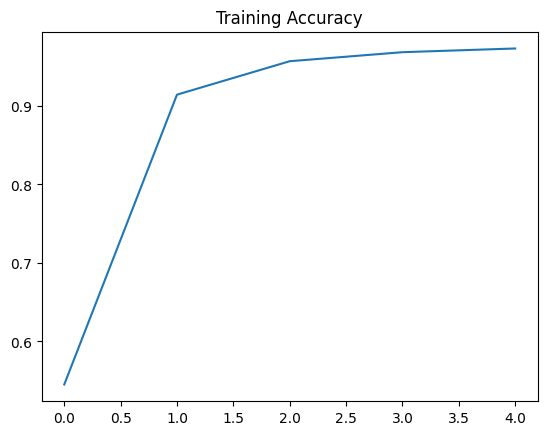

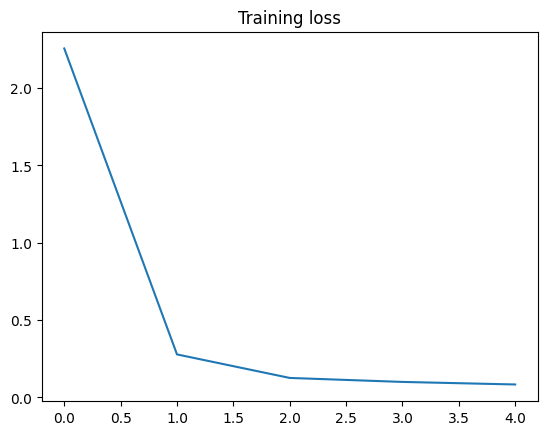

In [283]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.title('Training Accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.title('Training loss')

In [284]:
# history.history

**Predictions - Perform predictions on test images**

In [286]:
import keras.utils as image

In [293]:
# img_path = r"E:\Github\ML-NLP-Assignment\data\test\Form-13F\0b3b0f1e-1a18-43c6-833f-7ce283ac5862-1.png"
temp = convert_from_path(r"E:\Github\ML-NLP-Assignment\data\test_1.pdf", fmt='png', output_folder=r"E:\Github\ML-NLP-Assignment\data", first_page=1, last_page=1)

In [294]:
img_path = r"E:\Github\ML-NLP-Assignment\data\a4911eeb-7eb5-479a-a29c-1dd0f61e2d72-1.png"

1/1 [==============================] - 1s 552ms/step


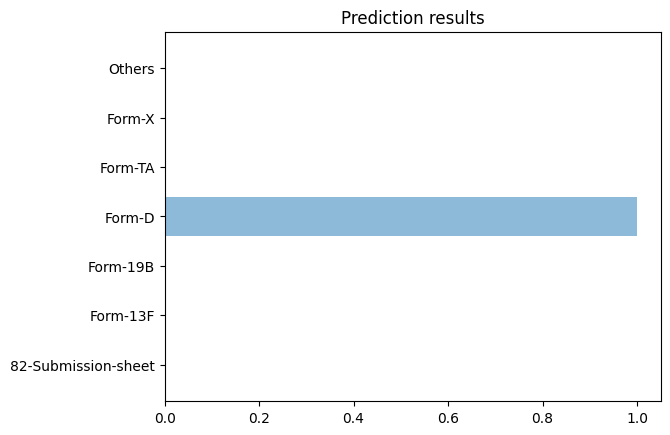

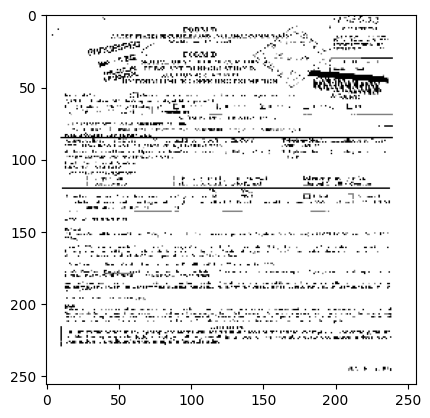

predicted [[8.1658265e-12 2.6730058e-08 1.3589371e-09 1.0000000e+00 6.9035153e-13
  2.8848727e-11 1.4937682e-12]]


In [298]:
img = image.load_img(img_path, target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(img, axis=0)

ind_pred = model_final.predict(x)

y_pos = np.arange(len(labels))
score = ind_pred
score_up = np.ravel(score)
plt.barh(y_pos, score_up, align='center', alpha=0.5)
plt.yticks(y_pos, labels)
plt.title("Prediction results")
plt.show()
plt.imshow(img)
plt.show()
print("predicted", score)

**Model Serialization - Save model in Tf format**

In [297]:
model_final.save("../saved_models/Doc_classifier_vgg16")

INFO:tensorflow:Assets written to: Doc_classifier_final\assets


INFO:tensorflow:Assets written to: Doc_classifier_final\assets


In [ ]:
# Convert ipynb to Python file

In [299]:
!jupyter nbconvert Document_classification.ipynb --to python

[NbConvertApp] Converting notebook Document_classification.ipynb to python
[NbConvertApp] Writing 10961 bytes to Document_classification.py


## Model Metrics

In [302]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [316]:
# test_datagen = ImageDataGenerator()
# test_loader = test_datagen.flow_from_directory(test_dir)
# batch_size = 32

# # if self.saved_model_path:
# #     model = tf.keras.models.load_model(self.saved_model_path)

# # Predictions on test data
# y_true = test_loader.classes
# y_pred_probs = model_final.predict(test_loader, steps=test_loader.n // batch_size + 1)
# y_pred = np.argmax(y_pred_probs, axis=1)

# accuracy = accuracy_score(y_true, y_pred)
# precision = precision_score(y_true, y_pred, average='weighted')
# recall = recall_score(y_true, y_pred, average='weighted')
# f1 = f1_score(y_true, y_pred, average='weighted')

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")
# print("Classification Report:")
# print(classification_report(y_true, y_pred, target_names=test_loader.class_indices.keys()))
# print("Confusion Matrix:")
# print(confusion_matrix(y_true, y_pred))

# # predictions = [labels[k] for k in predicted_class_indices]
# # print(predictions[:10])



In [312]:
test_datagen = ImageDataGenerator()
test_loader = test_datagen.flow_from_directory(test_dir, shuffle=False)
batch_size = 32


model = tf.keras.models.load_model("../saved_models/Doc_classifier_vgg16")

# Predictions on test data
y_true = test_loader.classes
y_pred_probs = model.predict(test_loader, steps=test_loader.n // batch_size + 1)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_loader.class_indices.keys()))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Found 181 images belonging to 7 classes.
6/6 [==============================] - 26s 4s/step
Accuracy: 0.9060773480662984
Precision: 0.9181063434779675
Recall: 0.9060773480662984
F1 Score: 0.9039874850667677
Classification Report:
                     precision    recall  f1-score   support

82-Submission-sheet       0.89      1.00      0.94        24
           Form-13F       1.00      0.73      0.84        33
           Form-19B       0.96      1.00      0.98        22
             Form-D       0.91      1.00      0.96        32
            Form-TA       0.95      0.95      0.95        22
             Form-X       0.95      0.75      0.84        24
             Others       0.74      0.96      0.84        24

           accuracy                           0.91       181
          macro avg       0.91      0.91      0.91       181
       weighted avg       0.92      0.91      0.90       181

Confusion Matrix:
[[24  0  0  0  0  0  0]
 [ 0 24  1  3  0  1  4]
 [ 0  0 22  0  0  0  0]
 [ 0  

In [ ]:
# For creating augmented images from test images, for better evaluation of models

In [311]:
# transform = A.Compose([
#     A.RandomRotate90(),
#     A.OneOf([
#         A.MotionBlur(p=.2),
#         A.MedianBlur(blur_limit=3, p=0.1),
#         A.Blur(blur_limit=3, p=0.1)
#     ], p=0.2),
#     A.OneOf([A.OpticalDistortion(p=0.3), A.GridDistortion(p=0.1)]),
#     A.OneOf([A.RandomBrightnessContrast(), A.CLAHE(clip_limit=2)]),
#     A.HueSaturationValue(p=0.3)
# ])

# # Loop through train directory to find number of pdfs for each class
# for idx, path in enumerate(os.listdir(test_dir)):
#     img_class_path = os.path.join(test_dir, path)
    
    
#     target_no_of_images = 20
    
#     # if path !=  'Form-13F':
#     no_of_images = len(os.listdir(img_class_path))
#     print(path)
#     for img_path in tqdm(os.listdir(img_class_path)):
#         img_full_path = os.path.join(img_class_path, img_path)
#         # for i in range(target_no_of_images - path_dict[path] + 1):
#         batch_size = round((target_no_of_images - no_of_images) /no_of_images)
#         for i in range(0, batch_size+1):
#             image = cv2.imread(img_full_path)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             # print(image)
#             augmented_image = transform(image=image)['image']
#             cv2.imwrite(os.path.join(img_class_path, f"augmented_{i}"+ img_path), augmented_image)       

82-Submission-sheet


  0%|          | 0/3 [00:00<?, ?it/s]

Form-13F


  0%|          | 0/11 [00:00<?, ?it/s]

Form-19B


  0%|          | 0/2 [00:00<?, ?it/s]

Form-D


  0%|          | 0/8 [00:00<?, ?it/s]

Form-TA


  0%|          | 0/2 [00:00<?, ?it/s]

Form-X


  0%|          | 0/6 [00:00<?, ?it/s]

Others


  0%|          | 0/4 [00:00<?, ?it/s]

**PS:** 

For fully class based implementation of the above code, please refer to **'src/doc_classifer_dl.py'**, where all the above code has been modularized and implemented for batch as well as single image predictions - deployed using Gradio

-----

#### Author: Vishak Gopkumar
#### Date: 24-09-2023